# Практическое задание

## 1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load data
df = pd.read_csv('/content/drive/MyDrive/Introduction to neural networks/data_sets/airline-passengers.csv', parse_dates=['Month'], index_col=0)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


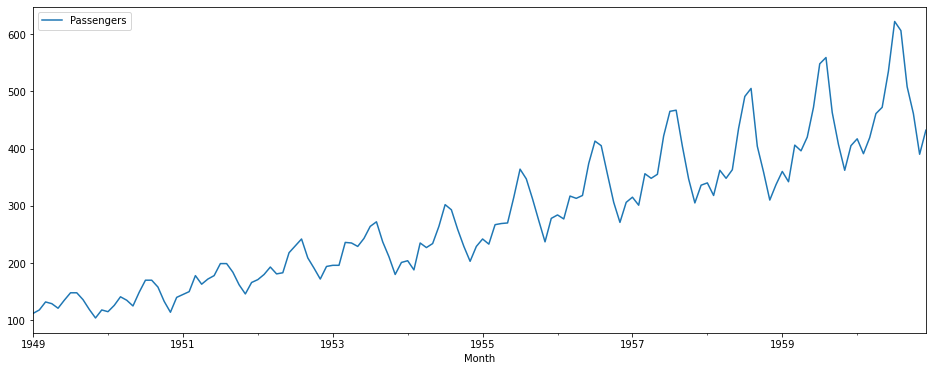

In [3]:
# view data
df.plot(figsize=(16, 6))
plt.show()

In [4]:
# featuring
df['year'] = df.index.year
df['month'] = df.index.month
# df.reset_index(inplace=True)

print(df.shape)
df.head()

(144, 3)


,Passengers,year,month
Month,,,
1949-01-01,112,1949,1
1949-02-01,118,1949,2
1949-03-01,132,1949,3
1949-04-01,129,1949,4
1949-05-01,121,1949,5


In [5]:
split = 100

train = df[:split]
test = df[split:]

X_train = train.iloc[:,-2:]
y_train = train['Passengers']

X_test = test.iloc[:,-2:]
y_test = test['Passengers']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(100, 2)
(100,)
(44, 2)
(44,)


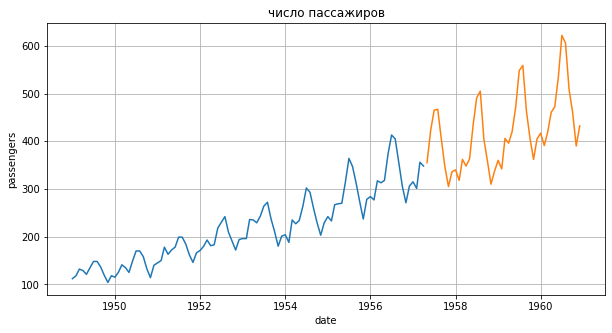

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.grid()
plt.xlabel('date')
plt.ylabel('passengers')
plt.title('число пассажиров')
plt.show()

In [7]:
dataset_train = timeseries_dataset_from_array(
    X_train, y_train,
    sequence_length=3,
    sampling_rate=1,
    batch_size=32
)
dataset_test = timeseries_dataset_from_array(
    X_test, y_test,
    sequence_length=3,
    sampling_rate=1,
    batch_size=32
)

In [8]:
for batch in dataset_train.take(2):
  inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 3, 2)
Target shape: (32,)


1 kernels, mse:
	Train: 49644.78125
	Test: 179778.296875
2 kernels, mse:
	Train: 49329.171875
	Test: 179153.890625
4 kernels, mse:
	Train: 48042.3046875
	Test: 176596.375
8 kernels, mse:
	Train: 45362.0546875
	Test: 171206.921875
16 kernels, mse:
	Train: 31196.671875
	Test: 140912.03125
32 kernels, mse:
	Train: 10401.1220703125
	Test: 83427.4375
64 kernels, mse:
	Train: 6517.39306640625
	Test: 34832.5859375
128 kernels, mse:
	Train: 6953.27294921875
	Test: 32977.5546875


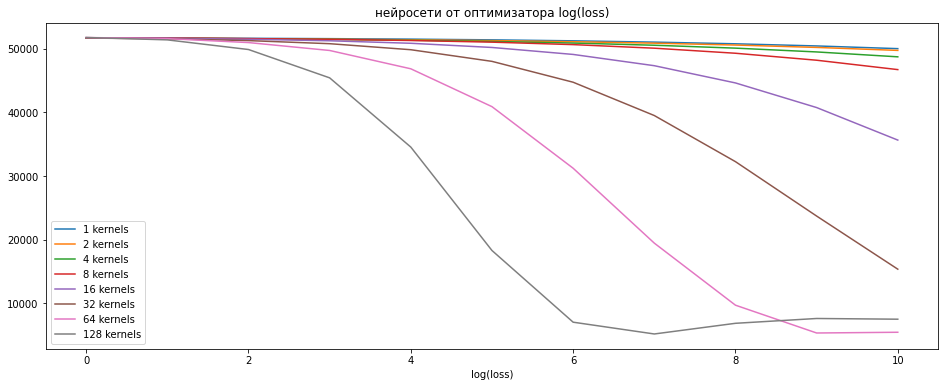

In [9]:
callback = EarlyStopping(monitor='val_mse', patience=5)

epochs = 10

plt.figure(figsize=(16, 6))

for kernels in (1, 2, 4, 8, 16, 32, 64, 128):

  model = Sequential([
      LSTM(kernels, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(kernels, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

  model.compile(loss="mse", 
                optimizer="nadam", 
                metrics=['mse'])

  hh0_train = model.evaluate(dataset_train, verbose=0)

  hh_train = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_test,
      callbacks=[callback], 
      verbose=0
  )

  hh1_train = model.evaluate(dataset_train, verbose=0)
  hh_test = model.evaluate(dataset_test, verbose=0)

  print(f"{kernels} kernels, mse:")
  print(f"\tTrain: {hh1_train[1]}")
  print(f"\tTest: {hh_test[1]}")

  plt.plot(range(epochs+1), [hh0_train[0]] + hh_train.history['loss'], label=f'{kernels} kernels')

plt.legend()
plt.title('нейросети от оптимизатора log(loss)')
plt.xlabel('epoch')
plt.xlabel('log(loss)')
plt.show()

## Введение:
- чем меньше число ядер, тем медленнее обучение
- 1 ядро не влияет на обучение
- при числе ядер = 128, ошибка на test начинает возрастать

1 kernels, mse:
	Train: 38548.39453125
	Test: 157067.828125
2 kernels, mse:
	Train: 32444.19140625
	Test: 143733.875
4 kernels, mse:
	Train: 23825.509765625
	Test: 123345.859375
8 kernels, mse:
	Train: 13909.2705078125
	Test: 95663.53125
16 kernels, mse:
	Train: 5495.1806640625
	Test: 55963.05859375
32 kernels, mse:
	Train: 6536.20361328125
	Test: 34745.34375
64 kernels, mse:
	Train: 7047.42431640625
	Test: 32615.677734375
128 kernels, mse:
	Train: 6741.69921875
	Test: 33837.4765625


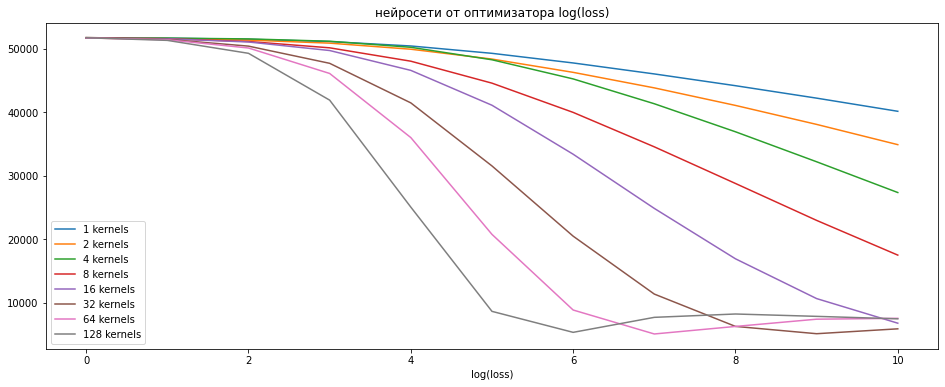

In [10]:
callback = EarlyStopping(monitor='val_mse', patience=5)

epochs = 10

plt.figure(figsize=(16, 6))

for kernels in (1, 2, 4, 8, 16, 32, 64, 128):

  model = Sequential([
      LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(128, return_sequences="True"),
      Conv1D(kernels, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

  model.compile(loss="mse", 
                optimizer="nadam", 
                metrics=['mse'])

  hh0_train = model.evaluate(dataset_train, verbose=0)

  hh_train = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_test,
      callbacks=[callback], 
      verbose=0
  )

  hh1_train = model.evaluate(dataset_train, verbose=0)
  hh_test = model.evaluate(dataset_test, verbose=0)

  print(f"{kernels} kernels, mse:")
  print(f"\tTrain: {hh1_train[1]}")
  print(f"\tTest: {hh_test[1]}")

  plt.plot(range(epochs+1), [hh0_train[0]] + hh_train.history['loss'], label=f'{kernels} kernels')

plt.legend()
plt.title('нейросети от оптимизатора log(loss)')
plt.xlabel('epoch')
plt.xlabel('log(loss)')
plt.show()

## Вывод:
- при числе ядер для conv1d = 128 - ошибка на test начинает возрастать

In [11]:
model1 = Sequential([
      LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

model2 = Sequential([
      LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(128, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

model3 = Sequential([
      LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(128, return_sequences="True"),
      LSTM(128, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

model4 = Sequential([
      LSTM(128, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"),
      LSTM(128, return_sequences="True"),
      LSTM(128, return_sequences="True"),
      LSTM(128, return_sequences="True"),
      Conv1D(64, 3, activation="linear"),
      Flatten(),
      Dense(64, activation="linear"),
      Dense(1, activation="linear"),
  ])

128 kernels, mse:
	Train: 6941.3671875
	Test: 67467.8125
128 kernels, mse:
	Train: 7086.8837890625
	Test: 32467.470703125
128 kernels, mse:
	Train: 6798.7939453125
	Test: 33598.578125
128 kernels, mse:
	Train: 6640.0869140625
	Test: 34276.51171875


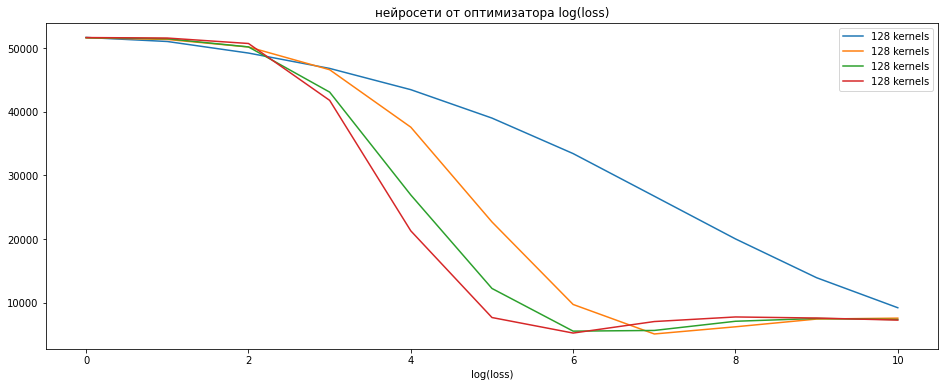

In [12]:
callback = EarlyStopping(monitor='val_mse', patience=5)

epochs = 10

plt.figure(figsize=(16, 6))

for model in (model1, model2, model3, model4):

  model.compile(loss="mse", 
                optimizer="nadam", 
                metrics=['mse'])

  hh0_train = model.evaluate(dataset_train, verbose=0)

  hh_train = model.fit(
      dataset_train,
      epochs=epochs,
      validation_data=dataset_test,
      callbacks=[callback], 
      verbose=0
  )

  hh1_train = model.evaluate(dataset_train, verbose=0)
  hh_test = model.evaluate(dataset_test, verbose=0)

  print(f"{kernels} kernels, mse:")
  print(f"\tTrain: {hh1_train[1]}")
  print(f"\tTest: {hh_test[1]}")

  plt.plot(range(epochs+1), [hh0_train[0]] + hh_train.history['loss'], label=f'{kernels} kernels')

plt.legend()
plt.title('нейросети от оптимизатора log(loss)')
plt.xlabel('epoch')
plt.xlabel('log(loss)')
plt.show()

## Вывод:
- модель с 2 слоями показывает лучший результат

## 2. *Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM</br>

## 3. *Предложите свои варианты решения проблемы исчезающего градиента в RNN